**Emotion Recognition based on facial landmarks**

This part of the practical session is about **emotion recognition** based on facial landmarks. We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) to recognize the emotion of a person by analyzing 68 facial landmarks (already estimated and placed). Below, you will find a picture with an example. We will focus on two emotions neutral and happy.

Please answer all questions and complete the code where you see **XXXXXXXXXXXXX**

**Deadline**: Upload this notebook, the one about Toy Examples and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

First of all, we need to load the data. In Google Colab, we can load from Google Drive or from our local machine. Since it's faster from Google Drive, let's load them from (my) Google Drive, using the following code.

In [4]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
  dest_path='./Data_FEI.npz')
  gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
  dest_path='./facial_landmarks_68markup.jpg')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
Working_directory="./data/"    

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


Otherwise, you can also load them from your local machine using the following code

In [ ]:
"""
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""      

Let's load the Python packages containing the functions needed for the practical session.

In [2]:
import numpy as np
from time import time

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# this is needed to plot figures within the notebook
%matplotlib inline 
np.random.seed(seed=666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

from sklearn.pipeline import make_pipeline

We also load a user-defined function useful for plotting the confusion matrix

In [3]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Now, let's load the data. 

We have a list of images, the position of the original landmarks (aligned to the images), the position of the landmarks after a normalization process called Generalized Procrustes Analysis (please refer to https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis), the outputs with the class labels and the names of the images.

Generalized Procrustes Analysis (GPA) is used to keep only shape differences between the configurations of landmarks. That is to say, we align all configurations to an average one using only rigid transformations (uniform scaling, rotation and translation). This means that if I take a facial picture of subject A, then step back, translate and rotate a bit the camera and retake a facial picture of the same subject (who has not moved) the two picture will be different with therefore different landmark position. However, after a GPA, the two landmark configurations should be perfectly aligned removing the "nuisance" differences related to rotation, translation and uniform scaling.

In [5]:
# Parameters
dim=2 # dimension   
# Loading data
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    X = data['Landmarks_FEI'] # original landmarks   
    XGPA = data['Landmarks_FEI_GPA'] # landmarks after GPA (Generalized Procrustes Analysis, https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis)
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = X.shape # number subjects 
M = int(M/2) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

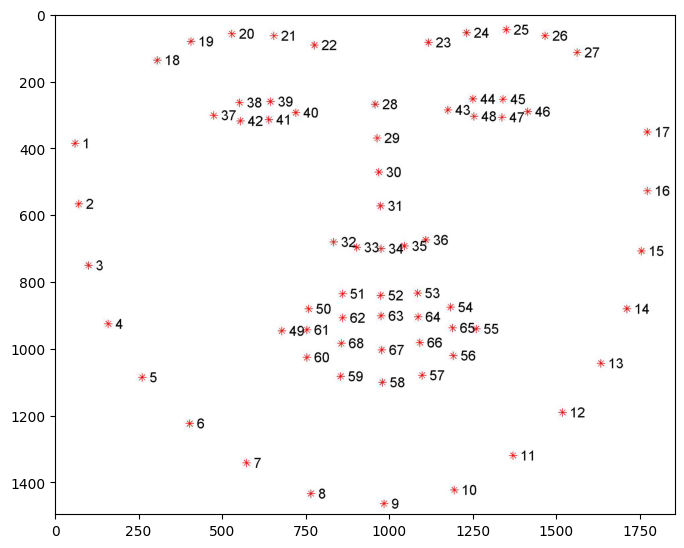

In [6]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (8,8)) # Size of the plot
plt.imshow(Example)
plt.show()

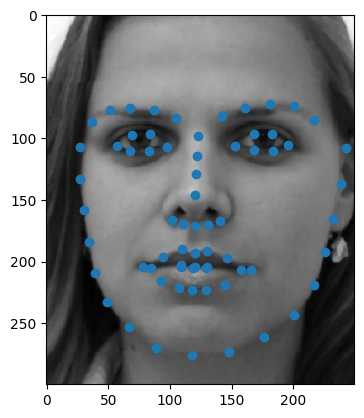

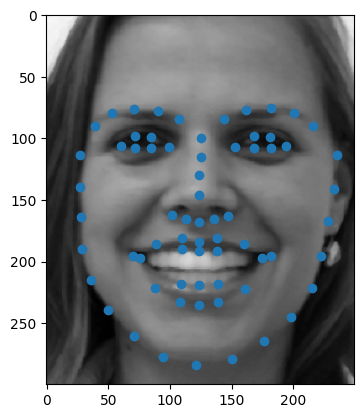

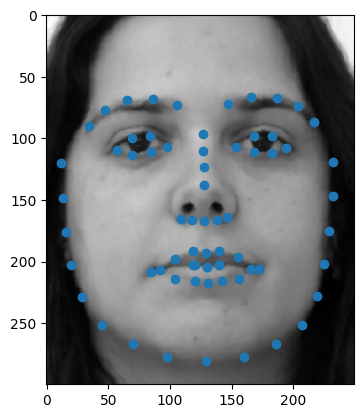

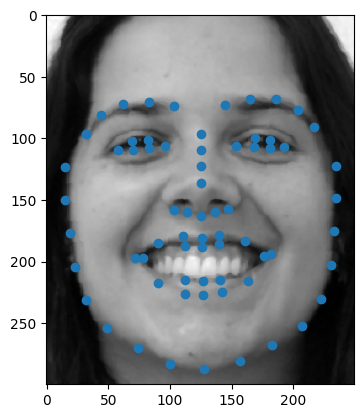

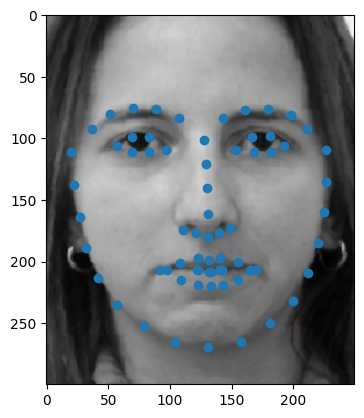

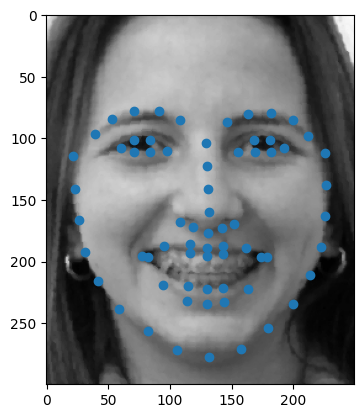

In [7]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Images[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()



---



**Question**: after plotting the first 6 images of the data-set, what do you notice ? Do you notice a regular pattern ? Do you think that it would be worth it to randomly shuffle the data ?\
\
**Answer:** The images come in pairs, the first one is a neutral face and the second one is the same person but with a happy face. In order to avoid biases, shuffling the data seems necessary.


---



In [19]:
# Shuffle data randomly. Hint: Use np.random.shuffle
indeces=np.linspace(0,N-1,N).astype(int)
np.random.shuffle(indeces)

XpGPA=XGPA[indeces]
Xp=X[indeces]
Yp=Y[indeces]
Imagesp=Images[indeces]
Xmean = np.mean(XpGPA,axis=0) # Compute average

Namesp=[''] * N
for i in range(0,N):
    Namesp[i]=Names[indeces[i]]   



---



Among the loaded data, we also have aligned landmarks after a Generalized Procrustes Analysis. Let's check them and compare them with the landmarks before alignement.


**QUESTION**: Please comment the results. What can you notice ?\
\
**Answer:** After GPA, we can still see the difference between the happy class and the neutral class, namely on the shape of the mouth but the variability due to the shape of the head seems to have been reduced, the landmarks that constitute the border of the face take up way less space.




---



Text(0.5, 1.0, 'Landmarks BEFORE alignement (GPA)')

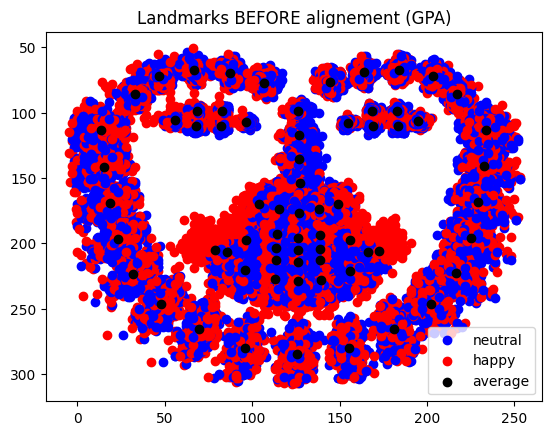

In [20]:
# Plot all landmarks BEFORE GPA
plt.figure()
for i in range(0,N):
    landmark=Xp[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
Xaverage = np.mean(Xp,axis=0) # Compute average
average=plt.scatter(Xaverage[::2],Xaverage[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis() 
plt.title('Landmarks BEFORE alignement (GPA)')

Text(0.5, 1.0, 'Landmarks AFTER alignement (GPA)')

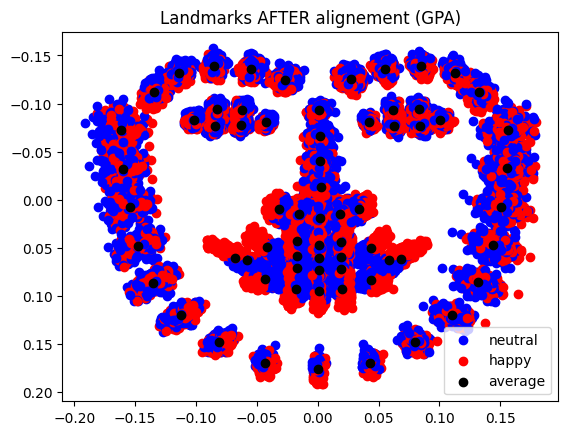

In [21]:
# Plot all landmarks AFTER GPA
plt.figure()
for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
average=plt.scatter(Xmean[::2],Xmean[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis()   
plt.title('Landmarks AFTER alignement (GPA)')



---


We need now to compute some features for the classification algorithms. As first idea, we could use the paired Euclidean distances between the landmarks of every subject and the landmarks of the average configuration. 



---



In [38]:
# Compute distances from the average configuration (features)
dist_average=np.zeros((N,M))
average=np.reshape(Xmean,(M,2)) # Reshape average as matrix

for i in range(N):
    landmark=XpGPA[i].reshape((-1,2)) # Reshape all landmarks as matrices
    dist_average[i]=np.linalg.norm(landmark-average,axis=1)

print('Number of subjects N is: ', dist_average.shape[0], ' ; number of features is: ',  dist_average.shape[1] )


Number of subjects N is:  400  ; number of features is:  68


Let's divide the data-set into Training and Test sets:

In [39]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(dist_average, np.ravel(Yp), test_size=0.33, random_state=42)

---

**Question**: One usual question in Machine Learning is, do we need to scale/normalize the features ? What do you think ? Should we do it in this case ? Compute both scaled and normalized data.\
\
**Answer:** Since the data we are using are distances between points, centering and sclaing them can reduce the disk space our data takes which makes our algorithm more efficicent.

Please note that we compute the parameters of 'StandardScaler()' and 'MinMaxScaler()' using only the training set and then we trasform both the traning and test sets using the parameters learnt only on the training set.

**Question**: Why do we do that in your opinion ?\
\
The goal is to train a model only on our training data ant then test it on the testing data. If we were to compute parameters for the testing set as well and use them to normalize it, we couldn't conclude on the efficiency of our program since we would have modified the test set to get a better result.

---

In [40]:
# Scale data (each feature will have average equal to 0 and unit variance)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale=scaler.transform(X_train)
X_test_scale=scaler.transform(X_test)

# Normalize data (each feature will be scaled into the range 0,1)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html?highlight=minmaxscaler#sklearn.preprocessing.MinMaxScaler

normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_normalize=normalizer.transform(X_train)
X_test_normalize=normalizer.transform(X_test)




---



Let's try to fit LDA to all training sets and predict the error on their respective test sets. 

**Question**: Compare the performnces between original, scaled and normalized data. Comment the results.\
\
**Answer:** The classification on the original training and testing sets was 10 times slower than on the scaled and normalized sets. However the results are exactly the same with a model accuracy of 51% which is really bad, we might as well decide by throwing a coin. 



---



Fitting LDA to training set
done in 0.215s
              precision    recall  f1-score   support

           0       0.56      0.48      0.52        73
           1       0.46      0.54      0.50        59

    accuracy                           0.51       132
   macro avg       0.51      0.51      0.51       132
weighted avg       0.52      0.51      0.51       132

Normalized confusion matrix
[[0.47945205 0.52054795]
 [0.45762712 0.54237288]]


<Figure size 640x480 with 0 Axes>

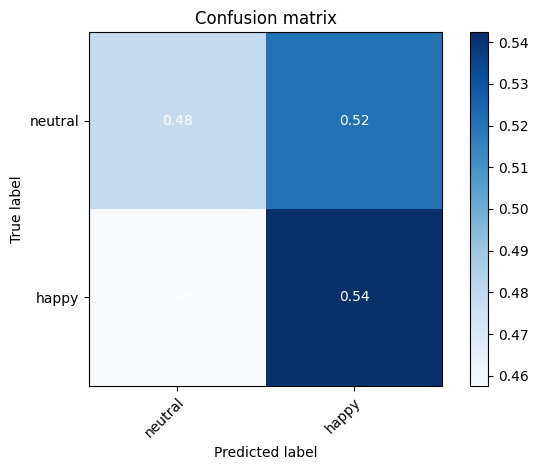

In [41]:
# Fitting LDA to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Fitting LDA to scaled training set
done in 0.021s
              precision    recall  f1-score   support

           0       0.56      0.48      0.52        73
           1       0.46      0.54      0.50        59

    accuracy                           0.51       132
   macro avg       0.51      0.51      0.51       132
weighted avg       0.52      0.51      0.51       132

Normalized confusion matrix
[[0.47945205 0.52054795]
 [0.45762712 0.54237288]]


<Figure size 640x480 with 0 Axes>

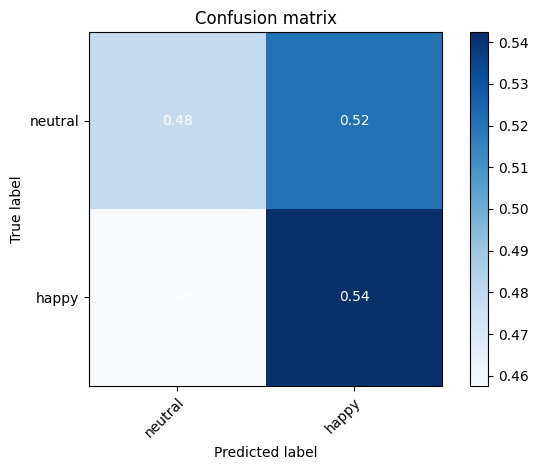

In [44]:
# Fitting LDA to scaled data
print("Fitting LDA to scaled training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred = lda.predict(X_test_scale)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Fitting LDA to normalized training set
done in 0.017s
              precision    recall  f1-score   support

           0       0.56      0.48      0.52        73
           1       0.46      0.54      0.50        59

    accuracy                           0.51       132
   macro avg       0.51      0.51      0.51       132
weighted avg       0.52      0.51      0.51       132

Normalized confusion matrix
[[0.47945205 0.52054795]
 [0.45762712 0.54237288]]


<Figure size 640x480 with 0 Axes>

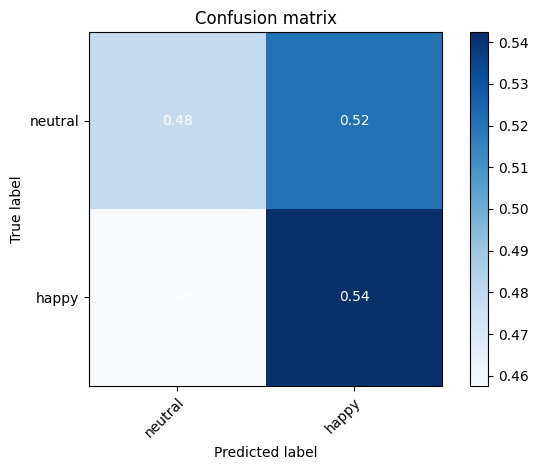

In [45]:
# Fitting LDA to normalized data
print("Fitting LDA to normalized training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_normalize, y_train)
y_pred = lda.predict(X_test_normalize)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()



---

We can then use the function 'cross_val_score' to compute the CV score. Let's use all methods seen today. 

---






In [46]:
# Cross-validation for Model Assessment

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.114s
 Average and std CV score : 0.5425000000000001 +- 0.0573367247058986
Fitting QDA
done in 0.084s
 Average and std CV score : 0.5599999999999999 +- 0.05385164807134504
Fitting Logistic Regression
done in 0.099s
 Average and std CV score : 0.515 +- 0.03657184709581948
Fitting Naive-Bayes
done in 0.014s
 Average and std CV score : 0.5974999999999999 +- 0.05556527692723216
Fitting K-nearest neighbour
done in 1.010s
 Average and std CV score : 0.5925 +- 0.047827816174272494


---
**Question**: compare the performances between original, scaled and normalized data

Be careful, if you want to standardize your data within a cross validation it means that you should fit 'StandardScaler()' only to the K-1 training folds without using the K-th test fold ! And then transform all folds.
How can we do that ? 

Scikit-learn gives us a very nice tool: THE PIPELINE ! It makes it easier to chain standardization, normalizations, etc. with estimators during a cross validation. Please have a look here: https://scikit-learn.org/stable/common_pitfalls.html

How can we build a Pipeline? It's very simple. Just concatenate the trasformation and the the estimator you want to use:

model = make_pipeline(StandardScaler(), LinearRegression())

---


In [49]:
# Cross-validation for Model Assessment with Standaridzation

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
gnb = make_pipeline(StandardScaler(), GaussianNB())
gnb_score = cross_val_score(gnb,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(gnb_score.mean(), gnb_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
knn_score = cross_val_score(knn,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(knn_score.mean(), knn_score.std() ))

Fitting LDA
done in 0.071s
 Average and std CV score : 0.5425000000000001 +- 0.0573367247058986
Fitting QDA
done in 0.068s
 Average and std CV score : 0.5599999999999999 +- 0.05385164807134504
Fitting Logistic Regression
done in 0.154s
 Average and std CV score : 0.5625 +- 0.046770717334674285
Fitting Naive-Bayes
done in 0.011s
 Average and std CV score : 0.5974999999999999 +- 0.05556527692723216
Fitting K-nearest neighbour
done in 0.042s
 Average and std CV score : 0.6074999999999999 +- 0.05454356057317855


In [50]:
# Cross-validation for Model Assessment with Normalization

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(MinMaxScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(MinMaxScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = make_pipeline(MinMaxScaler(), LogisticRegression(solver='lbfgs'))
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
gnb = make_pipeline(MinMaxScaler(), GaussianNB())
gnb_score = cross_val_score(gnb,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(gnb_score.mean(), gnb_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=3))
knn_score = cross_val_score(knn,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(knn_score.mean(), knn_score.std() ))

Fitting LDA
done in 0.079s
 Average and std CV score : 0.5425000000000001 +- 0.0573367247058986
Fitting QDA
done in 0.064s
 Average and std CV score : 0.5599999999999999 +- 0.05385164807134504
Fitting Logistic Regression
done in 0.087s
 Average and std CV score : 0.5675 +- 0.04716990566028299
Fitting Naive-Bayes
done in 0.021s
 Average and std CV score : 0.5974999999999999 +- 0.05556527692723216
Fitting K-nearest neighbour
done in 0.031s
 Average and std CV score : 0.5925 +- 0.04782781617427251


After comparing the cross-validation scores of the three sets, we can conclude that all three of them yield pretty similar results, with the scaled and normalized sets being at times 1% better than doing nothing. As said before however, using the last two sets is much faster.


---

In the previous example we have fixed the hyper-parameter K to 3. We could use CV to find the best value.

---



The best K is 9  with an average validation score equal to  0.6475000000000001


Text(0, 0.5, 'CV Validation Score')

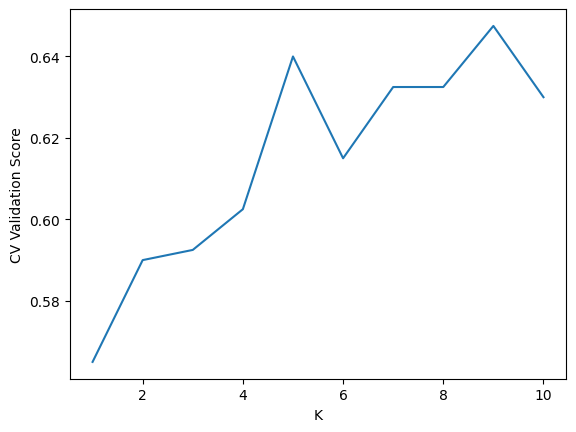

In [51]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_average, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')



---



We could also use CV to assess the prediction error (generalization error) in a left-out test set.



---



The best K is 9  with an average validation score equal to  0.6456324248777079
The test score is 0.5909090909090909


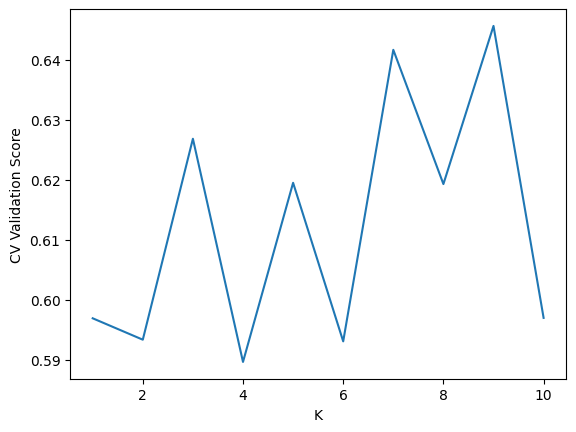

In [52]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))



---



**Question**: Comment the results of the two previosu experiments. What about the best K and validation/test error ? Are the results the same ? Why in your opinion ?\
\
The two previous experiments return the same result: the best number of neigbours to take is 9. This seems logical as having the best validation score must reduce the prediction error as well.



---





---



It seems that these features do not work very well... let's try to change them.
We can use the distances between all combinations of landmarks. Each subject has M*(M-1)/2 features.



---



In [53]:
# Use distances between all combinations of landmarks. Each subject has M*(M-1)/2 features
dist_combination=np.zeros((N,int((M*(M-1)/2))))

for i in range(N):
    landmark=XpGPA[i].reshape((-1,2)) # Reshape all landmarks as matrices
    dist=[]
    for j in range(M):
        for k in range(j+1,M):
            dist.append(np.linalg.norm(landmark[j]-landmark[k]))
    dist_combination[i] =dist

print('Number of subjects N is: ', dist_combination.shape[0], ' ; number of features is: ',  dist_combination.shape[1] )


Number of subjects N is:  400  ; number of features is:  2278


In [54]:
X2_train, X2_test, y2_train, y2_test = train_test_split(dist_combination, np.ravel(Yp), test_size=0.33, random_state=42)

**Question**: Should we scale/normalize the new features ?\
\
**Answer:** As seen before, scaling or normalizing the data drastically reduces computational time and since we've gone from 68 features to 2278, the effect is sure to be even greater. We should definitely do it.

Use the classification algorithms seen before to test the discriminative power of the new features. 

In [55]:
# Cross-validation for Model Assessment with Standaridzation

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
logit_score = cross_val_score(logit,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
gnb = make_pipeline(StandardScaler(), GaussianNB())
gnb_score = cross_val_score(gnb,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(gnb_score.mean(), gnb_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
knn_score = cross_val_score(knn,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(knn_score.mean(), knn_score.std() ))

Fitting LDA
done in 2.392s
 Average and std CV score : 0.8899999999999999 +- 0.024238399287081644
Fitting QDA


c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 1.919s
 Average and std CV score : 0.7 +- 0.05645794895318109
Fitting Logistic Regression
done in 1.755s
 Average and std CV score : 0.975 +- 0.013693063937629145
Fitting Naive-Bayes
done in 0.406s
 Average and std CV score : 0.9550000000000001 +- 0.023184046238739264
Fitting K-nearest neighbour
done in 0.419s
 Average and std CV score : 0.9349999999999999 +- 0.037416573867739396


In [56]:
# Cross-validation for Model Assessment with Normalization

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(MinMaxScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(MinMaxScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = make_pipeline(MinMaxScaler(), LogisticRegression(solver='lbfgs'))
logit_score = cross_val_score(logit,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
gnb = make_pipeline(MinMaxScaler(), GaussianNB())
gnb_score = cross_val_score(gnb,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(gnb_score.mean(), gnb_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=3))
knn_score = cross_val_score(knn,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(knn_score.mean(), knn_score.std() ))

Fitting LDA
done in 3.509s
 Average and std CV score : 0.8899999999999999 +- 0.024238399287081644
Fitting QDA


c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 1.946s
 Average and std CV score : 0.6225 +- 0.022912878474779203
Fitting Logistic Regression
done in 2.108s
 Average and std CV score : 0.9775 +- 0.018371173070873856
Fitting Naive-Bayes
done in 0.357s
 Average and std CV score : 0.9550000000000001 +- 0.023184046238739264
Fitting K-nearest neighbour
done in 0.352s
 Average and std CV score : 0.9450000000000001 +- 0.023184046238739254




---



mmmm it seems that some variables are collinear. Collinearity means that one variable can be linearly predicted by the others, basically it means that there is redundancy. 

**Question**: Which technique could you use to reduce the collinearity/redundancy ? Use it and test the predictive power of the new features.




---



In [66]:
from sklearn.decomposition import PCA
pca = PCA(random_state=1)
normalizer = MinMaxScaler()
dist_combination_norm = normalizer.fit_transform(dist_combination)
Ypca=pca.fit_transform(dist_combination_norm)
var_explained_pca=pca.explained_variance_ratio_
indeces = np.where(np.cumsum(var_explained_pca)>0.95)[0][0]
dist_combination_PCA = Ypca[:,:indeces]
print("In order to explain 95% of variabilty, we chose : " + str(indeces) + " features")

# Cross-validation for Model Assessment with Normalization

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_combination_PCA, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_combination_PCA, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_combination_PCA, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_combination_PCA, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_combination_PCA, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

In order to explain 95% of variabilty, we chose : 15 features
Fitting LDA
done in 0.127s
 Average and std CV score : 0.9574999999999999 +- 0.016955824957813163
Fitting QDA
done in 0.059s
 Average and std CV score : 0.9675 +- 0.012747548783981983
Fitting Logistic Regression
done in 0.170s
 Average and std CV score : 0.975 +- 0.017677669529663705
Fitting Naive-Bayes
done in 0.024s
 Average and std CV score : 0.9475 +- 0.02549509756796391
Fitting K-nearest neighbour
done in 0.132s
 Average and std CV score : 0.9475 +- 0.020000000000000018




---


A second solution, would be to manually select few landmarks



---



In [57]:
# Select lateral landmarks mouth
select_land=[49,50,60,55,54,56]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  12


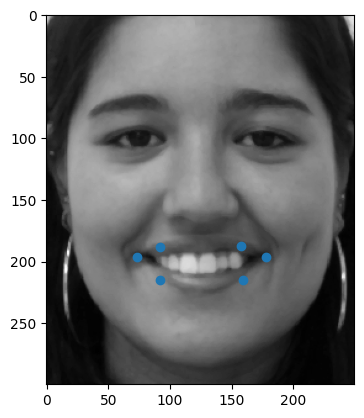

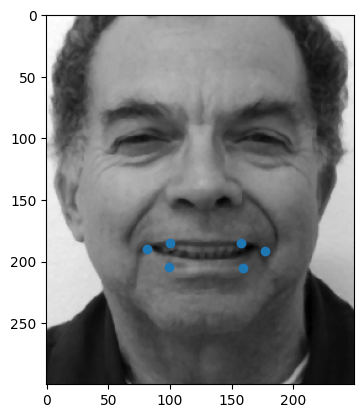

In [58]:
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

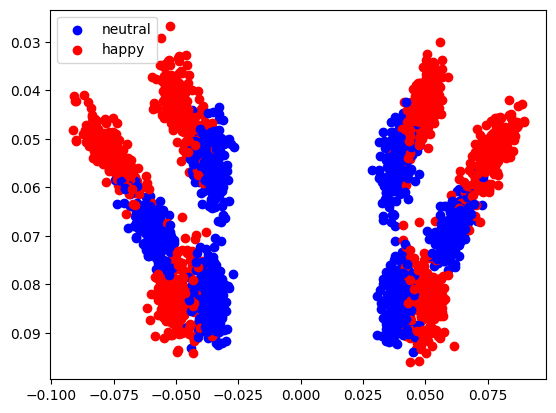

In [59]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [60]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.9556250000000001 +- 0.004592793267718473
 Average and std test score : 0.95 +- 0.023717082451262844


---

Let's plot some images where the best model was wrong. 

---

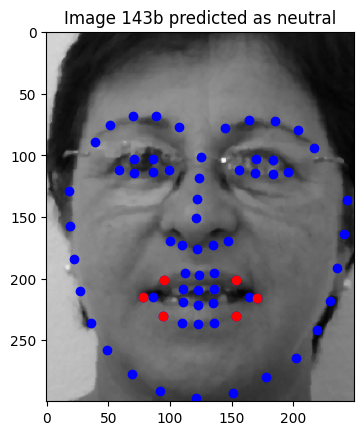

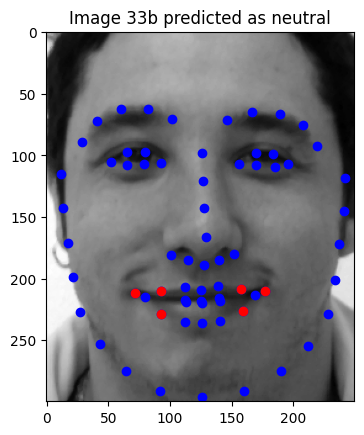

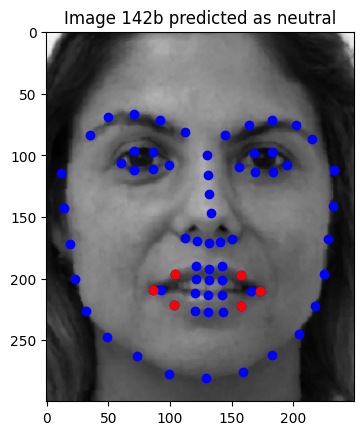

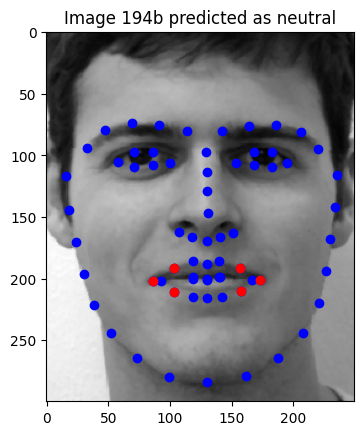

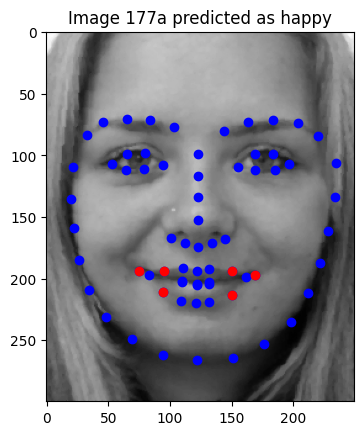

In [61]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 

**Question**: Comment the results. Why did the algorithm make a mistake ? Would you choose other landmarks ? Try at least another combination of landmarks\
\
**Answer:** The algorithm made a mistake because the shape of the lips of these persons are unusual, those who have large lips but aren't smiling are clasified as if they were and those who have thin lips but are smiling are considered to have a neutral face.\
\
Taking all the landmarks of the mouth was able to increase the cross validation scores to.98 and .95 and reduce the variance for both of them.


In [63]:
# Select all landmarks of the mouth
select_land=[49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  40


In [64]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.97625 +- 0.004238956239453287
 Average and std test score : 0.9525 +- 0.014577379737113245





---


Here, we use Nested Cross-Validation for finding the generalization error and the best K value



---



In [62]:
# Fitting K-nearest neighbour with Nested Cross-Validation
 
print("Fitting K-nearest neighbour with Nested CV")
t0 = time()
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666) # we fix the random state to always have the same results if we relaunch the code
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=neigh, param_grid=parameters, cv=inner_cv)
nested_CV = cross_validate(estimator=clf, X=XpsGPA, y=np.ravel(Yps), cv=outer_cv,return_train_score=True, return_estimator=True, n_jobs=-1)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv train score : {0} +- {1}".format(nested_CV['train_score'].mean(), nested_CV['train_score'].std() ))
print("Average and std Nested Cv test score : {0} +- {1}".format(nested_CV['test_score'].mean(), nested_CV['test_score'].std() ))

Fitting K-nearest neighbour with Nested CV
done in 8.049s
Average and std Nested Cv train score : 0.9574999999999999 +- 0.00852386356061617
Average and std Nested Cv test score : 0.9400000000000001 +- 0.020000000000000007


---

**Question**: Are Training and Test scores similar ? What does it mean ?\
\
**Answer:** The training and testing scores arereally close and both around .95. This means that our model was well trained (.96 train score) and that it has great repeatability, it can be used on other data as well (.94 test score).

---

**Question (OPTIONAL)**: Please propose at least another set of features using landmarks and/or pixel intensities of the images and test its discriminative power